# Complete experiment to try to estimate the probability of an offer to "succeed" with one customer. The "informative" offers are considered successful if the customer views them. Other kinds of offers are successful only if the customer views them, and then completes them.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [8]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [9]:
# Get the data
X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
    basic_dataset_path=STATIC_DATASET_PATH,
    drop_time=False)

# Time-split validation datasets
X_test = sd.drop_time_dependent(X_test)
X_train, X_val, y_train, y_val = sd.time_split(X_train_val, 
                                               y_train_val,
                                               time_limit=370)

In [10]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(38030, 13)
(38030,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
8,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0


In [11]:
print(X_val.shape)
print(y_val.shape)
X_val.head()

(12778, 13)
(12778,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
10,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0
15,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0
19,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
24,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0


In [12]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(25469, 13)
(25469,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_email,channel_social,channel_mobile
3,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
6,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
11,40.0,O,57000.0,0,17540,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
16,59.0,F,90000.0,0,16864,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0


## 2. Create the model <a id='model'/>
[Top](#top)

In [13]:
model = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer()),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

### Time-split Validation

In [14]:
trained_model, y_train_pred, y_val_pred = evos.time_split_validation(model)

Training time: 4.787968635559082 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16087  4045]
 [ 4389 13509]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     20132
           1       0.77      0.75      0.76     17898

   micro avg       0.78      0.78      0.78     38030
   macro avg       0.78      0.78      0.78     38030
weighted avg       0.78      0.78      0.78     38030

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[4969 1774]
 [1989 4046]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      6743
           1       0.70      0.67      0.68      6035

   micro avg       0.71

### Customer-split validation

In [15]:
evos.random_1fold_cust_validation(model)

Training time: 4.16239595413208 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[15009  3805]
 [ 3968 12791]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     18814
           1       0.77      0.76      0.77     16759

   micro avg       0.78      0.78      0.78     35573
   macro avg       0.78      0.78      0.78     35573
weighted avg       0.78      0.78      0.78     35573

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5941 2120]
 [2291 4883]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      8061
           1       0.70      0.68      0.69      7174

   micro avg       0.71 

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

This was the most basic estimator using XGBoost. Let's look at the feature importances.

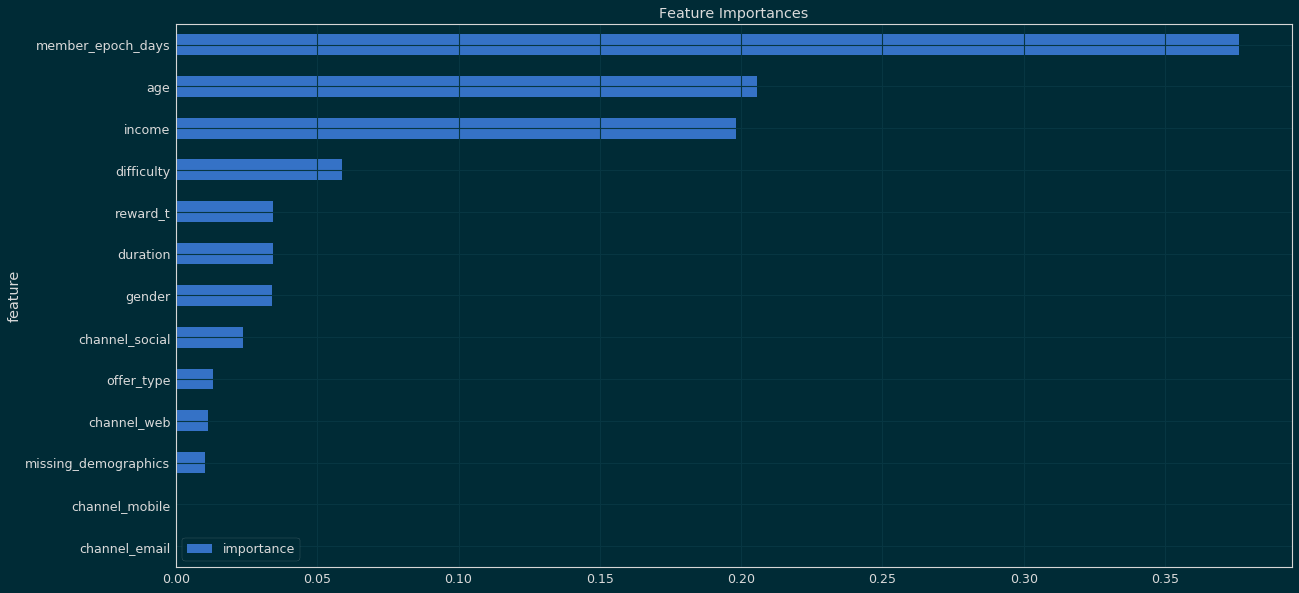

<Figure size 1440x720 with 0 Axes>

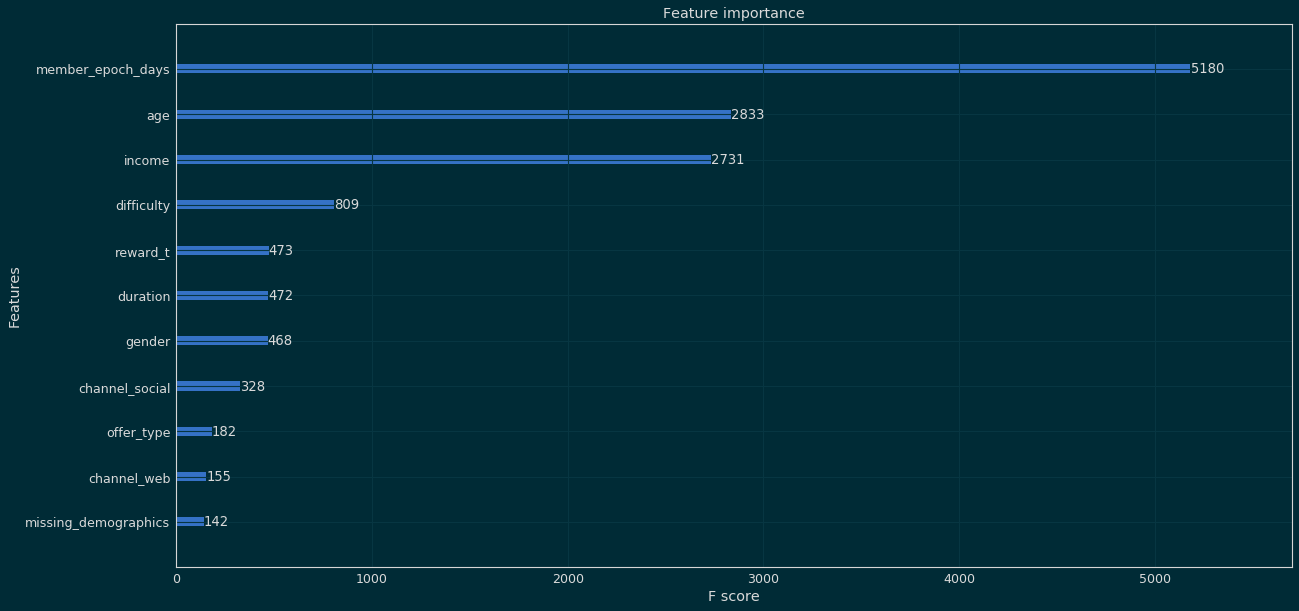

In [16]:
vis.show_feat_importances(model, X_train)

Clearly the date of registration, age and income seem to be the most important features.

## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [17]:
evos.offer_success_test(model)

Training time: 8.715197563171387 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[21243  5632]
 [ 6229 17704]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     26875
           1       0.76      0.74      0.75     23933

   micro avg       0.77      0.77      0.77     50808
   macro avg       0.77      0.77      0.77     50808
weighted avg       0.77      0.77      0.77     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10213  3775]
 [ 3552  7929]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74     13988
           1       0.68      0.69      0.68     11481

   micro avg       